In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention , LayerNormalization , Dropout , Layer
from tensorflow.keras.layers import Embedding , Input , GlobalAveragePooling1D , Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential , Model
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=np.VisibleDeprecationWarning)
import matplotlib.pyplot as plt

In [35]:
class TransformerBlock(Layer):
    def __init__(self,embed_dim,num_heads,ff_dim,rate=0.1):
        super(TransformerBlock,self).__init__()
        self.att= MultiHeadAttention(num_heads=num_heads,key_dim = embed_dim)
        self.ffn=Sequential([Dense(ff_dim,activation="sigmoid"),
                            Dense(embed_dim),]
        )
        self.layernorm1=LayerNormalization(epsilon=1e-6)
        self.layernorm2=LayerNormalization(epsilon=1e-6)
        self.dropout1=Dropout(rate)
        self.dropout2=Dropout(rate)
        
    def call(self,inputs,training):
        attn_output = self.att(inputs,inputs)
        attn_output=self.dropout1(attn_output,training=training)
        out1=self.layernorm1(inputs+attn_output)
        ffn_output=self.ffn(out1)
        ffn_output=self.dropout2(ffn_output,training=training)
        return self.layernorm2(out1+ffn_output)

In [36]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self,maxlen,vocab_size,embed_dim):
        super(TokenAndPositionEmbedding,self).__init__()
        self.token_emb=Embedding(input_dim=vocab_size,output_dim=embed_dim)
        self.pos_emb=Embedding(input_dim=maxlen,output_dim=embed_dim)
        
    def call(self,x):
        maxlen=tf.shape(x)[-1]
        positions=tf.range(start=0,limit=maxlen,delta=1)
        positions=self.pos_emb(positions)
        x=self.token_emb(x)
        return x + positions

In [54]:
vocab_size=20000
maxlen=200

(x_train,y_train),(x_val,y_val)=imdb.load_data(num_words=vocab_size)
print(len(x_train),"Training Sequences")
print(len(x_val),"Validation Sequences")

25000 Training Sequences
25000 Validation Sequences
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 10156, 4, 1153, 9, 194, 775, 7, 8255, 11596, 349, 2637, 148, 605, 15358, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


NameError: name 'count' is not defined

In [38]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_val=tf.keras.preprocessing.sequence.pad_sequences(x_val,maxlen=maxlen)

In [39]:
embed_dim=32
num_heads=2
ff_dim=32

inputs=Input(shape=(maxlen,))
embedding_layer=TokenAndPositionEmbedding(maxlen,vocab_size,embed_dim)
x=embedding_layer(inputs)
transformer_block=TransformerBlock(embed_dim,num_heads,ff_dim)
x=transformer_block(x)
x=GlobalAveragePooling1D()(x)
x=Dropout(0.1)(x)
x=Dense(20,activation="relu")(x)
x=Dropout(0.1)(x)
outputs=Dense(2,activation="softmax")(x)

model=Model(inputs=inputs,outputs=outputs)

In [40]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history=model.fit(x_train,y_train,
                 batch_size=64,epochs=2,
                 validation_data=(x_val,y_val)
                 )

Epoch 1/2
391/391 [==============================] - 100s 244ms/step - loss: 0.3980 - accuracy: 0.8125 - val_loss: 0.3132 - val_accuracy: 0.8682
Epoch 2/2
391/391 [==============================] - 96s 246ms/step - loss: 0.2089 - accuracy: 0.9192 - val_loss: 0.3266 - val_accuracy: 0.8726


In [23]:
model.save_weights("predict_class.h5")

In [41]:
results = model.evaluate(x_val,y_val,verbose=2)

for name,value in zip(model.metrics_names,results):
    print("%s: %.3f" %(name,value))

782/782 - 30s - loss: 0.3266 - accuracy: 0.8726 - 30s/epoch - 39ms/step
loss: 0.327
accuracy: 0.873


In [42]:
y_val[:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1], dtype=int64)

In [43]:
np.argmax(model.predict(x_val[1:2]))

1/1 [==============================] - 0s 387ms/step


1

In [44]:
np.argmax(model.predict(x_val[1:2]))

1/1 [==============================] - 0s 34ms/step


1

In [45]:
np.argmax(model.predict(x_val[2:3]))

1/1 [==============================] - 0s 37ms/step


1

In [50]:
sp = 0
nsp = 0
fp = 0
fn = 0
c = []
b=[]
n = int(input("Enter number of Reviews to check : "))
for i in range(0,n):
    a = np.argmax(model.predict(x_val[i:i+1]))
    if(a==y_val[i:i+1] and a == 1):
        sp = sp+1
        print("Accurate Result : Positive Review")
        c=np.append(c,i)
    elif(a==y_val[i:i+1] and a == 0):
        nsp = nsp+1
        print("Accurate Result : Negative Review")
        b=np.append(b,i)
    else:
        if(a!=y_val[i:i+1] and a==1):
            fp = fp+1
        elif(a!=y_val[i:i+1] and a==0):
            fn = fn+1
        print("Invalid Result")
    print(a,end = ""),print("->",end=""),print(y_val[i:i+1])
print("Accuracy : ",((sp+nsp)/n)*100,"%")
print("Positive Reviews : ",sp)
print("Negative Reviews : ",nsp)
print("Invalid Reviews : ",(n-(sp+nsp)))
rating =int(sp/(n/5))
print('Rating - ',end = "")
for i in range(0,rating):
    print("*",end="")

Enter number of Reviews to check : 500
1/1 [==============================] - 0s 36ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 34ms/step
Invalid Result
1->[0]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 40ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 34ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 35ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 33ms/step
Invalid Result
1->[0]
1/1 [==============================] - 0s 37ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 38ms/step
Accurate Result :

1/1 [==============================] - 0s 34ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 35ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 30ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 34ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 34ms/step
Invalid Result
0->

1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 34ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 30ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 31ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 35ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : 

1/1 [==============================] - 0s 28ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 37ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : 

1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 37ms/step
Invalid Result
0->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Invalid Result
0->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 31ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==========

1/1 [==============================] - 0s 31ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 28ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 36ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 35ms/step
Invalid Result
0->[1]
1/1 [==============================] - 0s 37ms/step
Accurate Result : Negative Review
0->[0]
1/1 [==============================] - 0s 33ms/step
Accurate Result : Positive Review
1->[1]
1/1 [==============================] - 0s 32ms/step
Accurate Result : Negative Review
0->

In [47]:
print(fp,fn)

2 0


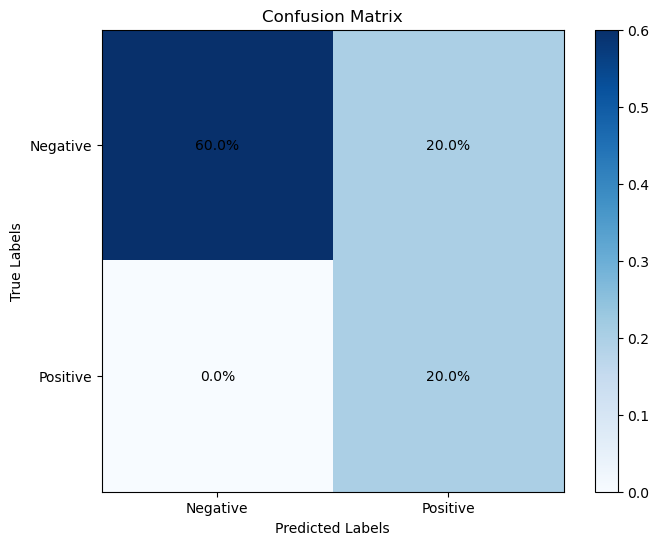

In [48]:
cn = [[sp , fp ],
     [fn , nsp]]

cn_norm = cn/np.sum(cn)
plt.figure(figsize=(8,6))

plt.imshow(cn_norm,cmap=plt.cm.Blues)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.colorbar()
for i in range(cn_norm.shape[0]):
    for j in range(cn_norm.shape[1]):
        plt.text(j, i, '{:.1%}'.format(cn_norm[i, j]), ha='center', va='center')

# Remove the grid lines
plt.grid(False)
plt.title('Confusion Matrix')
plt.show()

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

NameError: name 'roc_curve' is not defined